In [1]:
import pandas as pd
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# https://michelanders.blogspot.com/2010/12/calulating-sunrise-and-sunset-in-python.html
from math import cos, sin, acos, asin, tan
from math import degrees as deg, radians as rad
from datetime import date, datetime, time, tzinfo, timedelta
import time as _time


ZERO = timedelta(0)
HOUR = timedelta(hours=1)
SECOND = timedelta(seconds=1)

STDOFFSET = timedelta(seconds = -_time.timezone)
if _time.daylight:
    DSTOFFSET = timedelta(seconds = -_time.altzone)
else:
    DSTOFFSET = STDOFFSET

DSTDIFF = DSTOFFSET - STDOFFSET

class LocalTimezone(tzinfo):

    def fromutc(self, dt):
        assert dt.tzinfo is self
        stamp = (dt - datetime(1970, 1, 1, tzinfo=self)) // SECOND
        args = _time.localtime(stamp)[:6]
        dst_diff = DSTDIFF // SECOND
        # Detect fold
        fold = (args == _time.localtime(stamp - dst_diff))
        return datetime(*args, microsecond=dt.microsecond,
                        tzinfo=self, fold=fold)

    def utcoffset(self, dt):
        if self._isdst(dt):
            return DSTOFFSET
        else:
            return STDOFFSET

    def dst(self, dt):
        if self._isdst(dt):
            return DSTDIFF
        else:
            return ZERO

    def tzname(self, dt):
        return _time.tzname[self._isdst(dt)]

    def _isdst(self, dt):
        tt = (dt.year, dt.month, dt.day,
              dt.hour, dt.minute, dt.second,
              dt.weekday(), 0, 0)
        stamp = _time.mktime(tt)
        tt = _time.localtime(stamp)
        return tt.tm_isdst > 0

class sun:
    """
    Calculate sunrise and sunset based on equations from NOAA
    http://www.srrb.noaa.gov/highlights/sunrise/calcdetails.html

    typical use, calculating the sunrise at the present day:

    import datetime
    import sunrise
    s = sun(lat=49,long=3)
    print('sunrise at ',s.sunrise(when=datetime.datetime.now())
    """

    def __init__(self, lat=52.37, long=4.90):  # default Amsterdam
        self.lat = lat
        self.long = long

    def sunrise(self, when=None):
        """
        return the time of sunrise as a datetime.time object
        when is a datetime.datetime object. If none is given
        a local time zone is assumed (including daylight saving
        if present)
        """
        if when is None:
            when = datetime.now(tz=LocalTimezone())
        self.__preptime(when)
        self.__calc()
        return sun.__timefromdecimalday(self.sunrise_t)

    def sunset(self, when=None):
        if when is None:
            when = datetime.now(tz=LocalTimezone())
        self.__preptime(when)
        self.__calc()
        return sun.__timefromdecimalday(self.sunset_t)

    def solarnoon(self, when=None):
        if when is None:
            when = datetime.now(tz=LocalTimezone())
        self.__preptime(when)
        self.__calc()
        return sun.__timefromdecimalday(self.solarnoon_t)

    @staticmethod

    def __timefromdecimalday(day):
        """
        return a datetime.time object.
        day is a decimal day between 0.0 and 1.0, e.g. noon = 0.5
        """
        hours = 24.0*day
        h = int(hours)
        minutes = (hours-h)*60
        m = int(minutes)
        seconds = (minutes-m)*60
        s = int(seconds)
        return time(hour=h, minute=m, second=s)

    def __preptime(self, when):
        """
        Extract information in a suitable format from when,
        a datetime.datetime object.
        """
        # datetime days are numbered in the Gregorian calendar
        # while the calculations from NOAA are distibuted as
        # OpenOffice spreadsheets with days numbered from
        # 1/1/1900. The difference are those numbers taken for
        # 18/12/2010
        self.day = when.toordinal()-(734124-40529)
        t = when.time()
        self.time = (t.hour + t.minute/60.0 + t.second/3600.0)/24.0

        self.timezone = 0
        offset = when.utcoffset()
        if not offset is None:
            self.timezone = offset.seconds/3600.0

    def __calc(self):
        """
        Perform the actual calculations for sunrise, sunset and
        a number of related quantities.

        The results are stored in the instance variables
        sunrise_t, sunset_t and solarnoon_t
        """ 
        timezone = self.timezone  # in hours, east is positive
        longitude = self.long     # in decimal degrees, east is positive
        latitude = self.lat       # in decimal degrees, north is positive

        time = self.time  # percentage past midnight, i.e. noon  is 0.5
        day = self.day     # daynumber 1=1/1/1900

        Jday = day+2415018.5+time-timezone/24  # Julian day
        Jcent = (Jday-2451545)/36525    # Julian century

        Manom = 357.52911+Jcent*(35999.05029-0.0001537*Jcent)
        Mlong = 280.46646+Jcent*(36000.76983+Jcent*0.0003032) % 360
        Eccent = 0.016708634-Jcent*(0.000042037+0.0001537*Jcent)
        Mobliq = 23+(26+((21.448-Jcent*(46.815+Jcent*(0.00059-Jcent*0.001813))))/60)/60
        obliq = Mobliq+0.00256*cos(rad(125.04-1934.136*Jcent))
        vary = tan(rad(obliq/2))*tan(rad(obliq/2))
        Seqcent = sin(rad(Manom))*(1.914602-Jcent*(0.004817+0.000014*Jcent))+sin(rad(2*Manom))*(0.019993-0.000101*Jcent)+sin(rad(3*Manom))*0.000289
        Struelong = Mlong+Seqcent
        Sapplong = Struelong-0.00569-0.00478*sin(rad(125.04-1934.136*Jcent))
        declination = deg(asin(sin(rad(obliq))*sin(rad(Sapplong))))

        eqtime = 4*deg(vary*sin(2*rad(Mlong))-2*Eccent*sin(rad(Manom))+4*Eccent*vary*sin(rad(Manom))*cos(2*rad(Mlong))-0.5*vary*vary*sin(4*rad(Mlong))-1.25*Eccent*Eccent*sin(2*rad(Manom)))

        hourangle = deg(acos(cos(rad(90.833))/(cos(rad(latitude))*cos(rad(declination)))-tan(rad(latitude))*tan(rad(declination))))

        self.solarnoon_t = (720-4*longitude-eqtime+timezone*60)/1440
        self.sunrise_t = self.solarnoon_t-hourangle*4/1440
        self.sunset_t = self.solarnoon_t+hourangle*4/1440

#if __name__ == "__main__":
#s=sun(lat=52.37,long=4.90)
#print(datetime.today())
#print(s.sunrise(),s.solarnoon(),s.sunset())


In [3]:
s = sun(lat=47.264272 ,long=11.385294)
sr = s.sunrise()
tzinfo(sr)

In [4]:
file = 'SSD_IMGIinnsbruck.txt'  # http://ertel2.uibk.ac.at:8080/uploads-imgi/2012/03/SSD_IMGIinnsbruck.txt
colnames = ['MM', 'DD', 'SU', 'SA', 'SSD']
year = 2020
dateparser = lambda x: pd.datetime.strptime(x, '2020 %m %d')
df = pd.read_csv(file, 
                 header=21, 
                 delim_whitespace=True, 
                 names=colnames, 
                 #parse_dates={'Date': ['MM', 'DD']}, 
                 #keep_date_col=True,
                 index_col=False,
                 #date_parser=dateparser,
                )
df = df.set_index(pd.to_datetime({'year': year, 'month': df['MM'], 'day': df['DD']}))
df = df.drop(columns=['MM', 'DD'])

# converting times
tfun = lambda x: datetime.strptime(str(x), '%H%M').time()
df['SA_eff'] = df['SA'].apply(tfun)
df['SU_eff'] = df['SU'].apply(tfun)
df = df.drop(columns=['SU', 'SA'])


df = df.rename(columns={'SSD' : 'SSD_eff'})
df

,SSD_eff,SA_eff,SU_eff
2020-01-01,352,09:20:00,15:12:00
2020-01-02,352,09:20:00,15:12:00
2020-01-03,353,09:20:00,15:13:00
2020-01-04,354,09:18:00,15:14:00
2020-01-05,357,09:18:00,15:15:00
...,...,...,...
2020-12-27,349,09:20:00,15:09:00
2020-12-28,348,09:20:00,15:08:00
2020-12-29,349,09:20:00,15:09:00
2020-12-30,349,09:20:00,15:09:00


In [5]:
# apply astronomic sunrise & sunset

s = sun(lat=47.264272 ,long=11.385294)

risefun = lambda x: s.sunrise(when=x)
setfun = lambda x: s.sunset(when=x)

df['SA_ast'] = df.index.map(risefun)
df['SU_ast'] = df.index.map(setfun)

# convert to correct timezone (MEZ)
def time_plus(time, timedelta):
    start = datetime(
        2020, 1, 1,
        hour=time.hour, minute=time.minute, second=time.second)
    end = start + timedelta
    return end.time()

tplu = lambda x: time_plus(x, timedelta(hours = 1))
df['SA_ast'] = df['SA_ast'].apply(tplu)
df['SU_ast'] = df['SU_ast'].apply(tplu)

df

,SSD_eff,SA_eff,SU_eff,SA_ast,SU_ast
2020-01-01,352,09:20:00,15:12:00,08:01:14,16:32:53
2020-01-02,352,09:20:00,15:12:00,08:01:18,16:33:46
2020-01-03,353,09:20:00,15:13:00,08:01:19,16:34:42
2020-01-04,354,09:18:00,15:14:00,08:01:18,16:35:40
2020-01-05,357,09:18:00,15:15:00,08:01:13,16:36:39
...,...,...,...,...,...
2020-12-27,349,09:20:00,15:09:00,08:00:26,16:29:33
2020-12-28,348,09:20:00,15:08:00,08:00:42,16:30:16
2020-12-29,349,09:20:00,15:09:00,08:00:55,16:31:02
2020-12-30,349,09:20:00,15:09:00,08:01:06,16:31:50


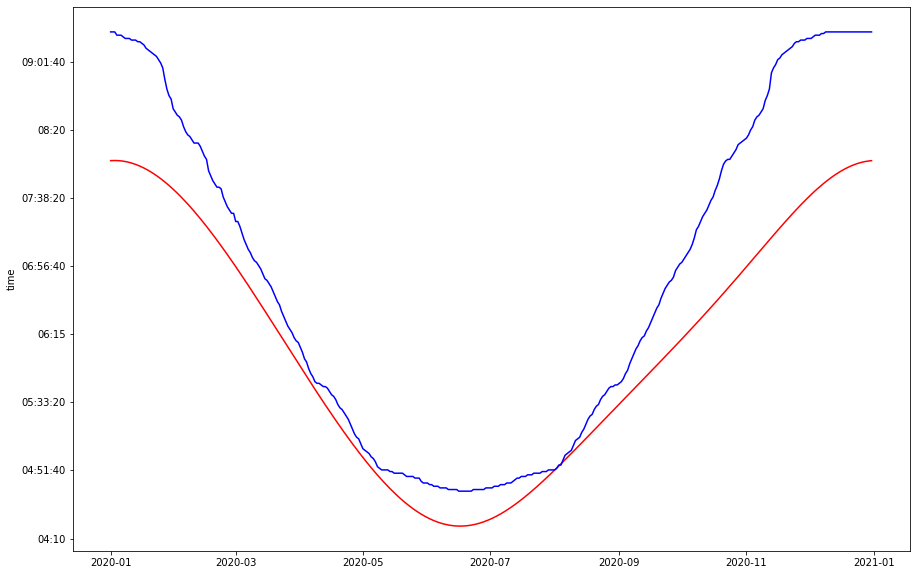

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot_date(df.index, df['SA_ast'], 'r');
ax.plot_date(df.index, df['SA_eff'], 'b');
plt.show();

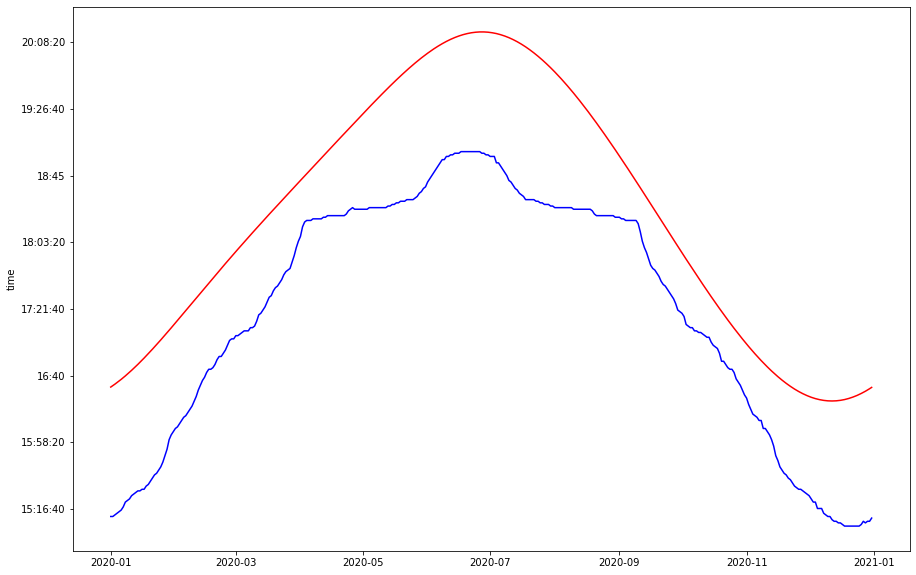

In [8]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot_date(df.index, df['SU_ast'], 'r');
ax.plot_date(df.index, df['SU_eff'], 'b');
plt.show();

In [43]:
# Convert times into total seconds
def total_seconds(timeobj):
    t = datetime.combine(date.min, timeobj) - datetime.min
    return t.total_seconds()


df['SA_ast_sec'] = df['SA_ast'].apply(total_seconds)
df['SU_ast_sec'] = df['SU_ast'].apply(total_seconds)
df['SA_eff_sec'] = df['SA_eff'].apply(total_seconds)
df['SU_eff_sec'] = df['SU_eff'].apply(total_seconds)

# Convert date into day of year
df['yearday'] = pd.Series()
for i in df.index:
    df['yearday'].loc[i] = i.timetuple().tm_yday
    
df

,SSD_eff,SA_eff,SU_eff,SA_ast,SU_ast,SA_ast_sec,SU_ast_sec,SA_eff_sec,SU_eff_sec,yearday
2020-01-01,352,09:20:00,15:12:00,08:01:14,16:32:53,28874.0,59573.0,33600.0,54720.0,1.0
2020-01-02,352,09:20:00,15:12:00,08:01:18,16:33:46,28878.0,59626.0,33600.0,54720.0,2.0
2020-01-03,353,09:20:00,15:13:00,08:01:19,16:34:42,28879.0,59682.0,33600.0,54780.0,3.0
2020-01-04,354,09:18:00,15:14:00,08:01:18,16:35:40,28878.0,59740.0,33480.0,54840.0,4.0
2020-01-05,357,09:18:00,15:15:00,08:01:13,16:36:39,28873.0,59799.0,33480.0,54900.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,349,09:20:00,15:09:00,08:00:26,16:29:33,28826.0,59373.0,33600.0,54540.0,362.0
2020-12-28,348,09:20:00,15:08:00,08:00:42,16:30:16,28842.0,59416.0,33600.0,54480.0,363.0
2020-12-29,349,09:20:00,15:09:00,08:00:55,16:31:02,28855.0,59462.0,33600.0,54540.0,364.0
2020-12-30,349,09:20:00,15:09:00,08:01:06,16:31:50,28866.0,59510.0,33600.0,54540.0,365.0


array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714])

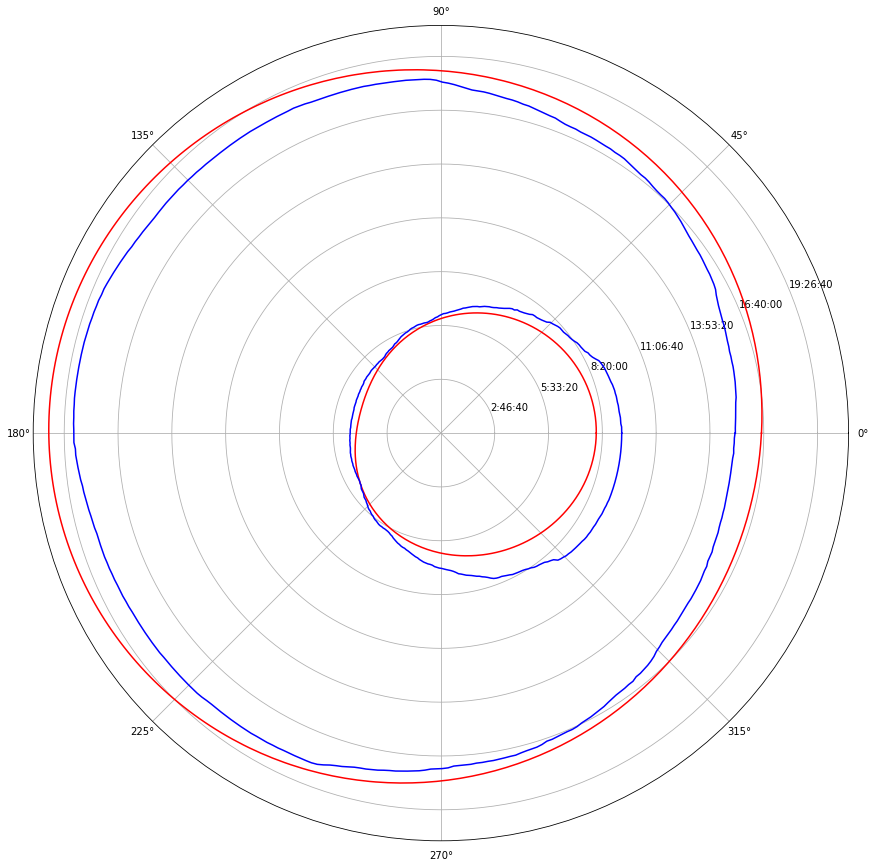

In [89]:
fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection='polar')
theta = np.linspace(0, 2*np.pi, 366)


plt.polar(theta,df['SU_ast_sec'], 'r' )
plt.polar(theta,df['SA_ast_sec'], 'r' )

plt.polar(theta,df['SA_eff_sec'], 'b' )
plt.polar(theta,df['SU_eff_sec'], 'b' )

# aranging y-ticks and labels
y_tick_dists =  np.arange(10000, 80000, step=10000)
timestring = lambda x: str(timedelta(seconds=float(x)))
timestring_v = np.vectorize(timestring)
yticks(y_tick_dists, timestring_v(y_tick_dists));

# aranging x-ticks and labels
#angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
#angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
#angles = np.rad2deg(angles)
#for label, angle in zip(ax.get_xticklabels(), angles):
#    print(label, angle)
ax.get_xticks()